# An Introduction to Algorithms for Qiskit

This is an introduction to algorithms for Qiskit and provides a high-level overview to help understand the various aspects of the functionality to get started. Other tutorials will provide more in-depth material, on given algorithms, and ways to use them etc.


## How is the algorithm library structured?

Qiskit provides a number of [Algorithms](https://qiskit.org/ecosystem/algorithms/apidocs/algorithms.html) and they are grouped by category according to the task they can perform. For instance [Minimum Eigensolvers](https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.minimum_eigensolvers.html#module-qiskit_algorithms.minimum_eigensolvers) to find the smallest eigen value of an operator, for example ground state energy of a chemistry Hamiltonian or a solution to an optimization problem when expressed as an Ising Hamiltonian. There are [Time Evolvers](https://qiskit.org/ecosystem/algorithms/apidocs/algorithms.html#time-evolvers) for the time evolution of quantum systems and [Amplitude Estimators](https://qiskit.org/ecosystem/algorithms/apidocs/algorithms.html#amplitude-estimators) for value estimation that can be used say in financial applications. The full set of categories can be seen in the Algorithms documentation link above.

Algorithms are configurable and often part of the configuration will be in the form of smaller building blocks, of which different instances of the building block type can be given. For instance with [VQE](https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.minimum_eigensolvers.VQE.html#qiskit_algorithms.minimum_eigensolvers.VQE), the Variational Quantum Eigensolver, it takes a trial wavefunction, in the form of a [QuantumCircuit](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#quantumcircuit) and a classical optimizer among other things.

Let's take a look at an example to construct a VQE instance. Here [TwoLocal](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html#twolocal) is the variational form (trial wavefunction), a parameterized circuit which can be varied, and [SLSQP](https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.optimizers.SLSQP.html#qiskit_algorithms.optimizers.SLSQP) a classical optimizer. These are created as separate instances and passed to VQE when it is constructed. Trying, for example, a different classical optimizer, or variational form is simply a case of creating an instance of the one you want and passing it into VQE.


In [2]:
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

num_qubits = 2
ansatz = TwoLocal(num_qubits, "ry", "cz")
optimizer = SLSQP(maxiter=1000)

Let's draw the ansatz so we can see it's a [QuantumCircuit](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.html#quantumcircuit) where θ\[0\] through θ\[7\] will be the parameters that are varied as VQE optimizer finds the minimum eigenvalue. We'll come back to the parameters later in a working example below.


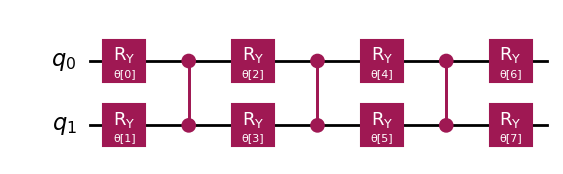

In [3]:
ansatz.decompose().draw("mpl", style="iqx")

But more is needed before we can run the algorithm so let's get to that next.


## How to run an algorithm?

Algorithms rely on the primitives to evaluate expectation values or sample circuits. The primitives can be based on a simulator or real device and can be used interchangeably in the algorithms, as they all implement the same interface.

In the VQE, we have to evaluate expectation values, so for example we can use the [qiskit.primitives.Estimator](https://qiskit.org/documentation/stubs/qiskit.primitives.Estimator.html) which is shipped with the default Qiskit Terra installation.


In [4]:
from qiskit.primitives import Estimator

estimator = Estimator()

This estimator uses an exact, statevector simulation to evaluate the expectation values. We can also use a shot-based and noisy simulators or real backends instead. For more information of the simulators you can check out [Qiskit Aer](https://qiskit.org/ecosystem/aer/apidocs/aer_primitives.html) and for the actual hardware [Qiskit IBM Runtime](https://qiskit.org/ecosystem/ibm-runtime/).

With all the ingredients ready, we can now instantiate the VQE:


In [5]:
from qiskit_algorithms.minimum_eigensolvers import VQE

vqe = VQE(estimator, ansatz, optimizer)

Now we can call the [compute_mininum_eigenvalue()](https://qiskit.org/ecosystem/algorithms/stubs/qiskit_algorithms.minimum_eigensolvers.VQE.html#qiskit_algorithms.minimum_eigensolvers.VQE.compute_minimum_eigenvalue) method. The latter is the interface of choice for the application modules, such as Nature and Optimization, in order that they can work interchangeably with any algorithm within the specific category.


## A complete working example

Let's put what we have learned from above together and create a complete working example. VQE will find the minimum eigenvalue, i.e. minimum energy value of a Hamiltonian operator and hence we need such an operator for VQE to work with. Such an operator is given below. This was originally created by the Nature application module as the Hamiltonian for an H2 molecule at 0.735A interatomic distance. It's a sum of Pauli terms as below, but for now I am not going to say anything further about it since the goal is to run the algorithm, but further information on operators can be found in other tutorials.


In [6]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

So let's run VQE and print the result object it returns.


In [7]:
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 54,
    'eigenvalue': -1.8572749751321997,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x10b47a050>,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): -4.137380786621057,
                              ParameterVectorElement(θ[0]): 0.587854208432134,
                              ParameterVectorElement(θ[2]): 5.638873652671935,
                              ParameterVectorElement(θ[3]): 6.15338799125403,
                              ParameterVectorElement(θ[4]): -1.6196994394795583,
                              ParameterVectorElement(θ[5]): -1.2567360775493952,
                              ParameterVectorElement(θ[6]): -2.2594501173878827,
                              ParameterVectorElement(θ[7]): 5.24757903057859},
    'optimal_point': array([ 0.58785421, -4.13738079,  5.63887365,  6.15338799, -1.61969944,
       -1.25673608, -2.25945012,  5.24757903]),
    'optimal_val

From the above result we can see the number of cost function (=energy) evaluations the optimizer took until it found the minimum eigenvalue of $\approx -1.85727$ which is the electronic ground state energy of the given H2 molecule. The optimal parameters of the ansatz can also be seen which are the values that were in the ansatz at the minimum value.


## Updating the primitive inside VQE

To close off let's also change the estimator primitive inside the a VQE. Maybe you're satisfied with the simulation results and now want to use a shot-based simulator, or run on hardware!

In this example we're changing to a shot-based estimator, still using Qiskit Terra's reference primitive. However you could replace the primitive by e.g. Qiskit Aer's estimator ([qiskit_aer.primitives.Estimator](https://qiskit.org/ecosystem/aer/stubs/qiskit_aer.primitives.Estimator.html#estimator)) or even a real backend ([qiskit_ibm_runtime.Estimator](https://qiskit.org/ecosystem/ibm-runtime/stubs/qiskit_ibm_runtime.Estimator.html#qiskit_ibm_runtime.Estimator)).

For noisy loss functions, the SPSA optimizer typically performs well, so we also update the optimizer. See also the [noisy VQE tutorial](https://qiskit.org/ecosystem/algorithms/tutorials/03_vqe_simulation_with_noise.html) for more details on shot-based and noisy simulations.


In [8]:
from qiskit_algorithms.optimizers import SPSA

estimator = Estimator(options={"shots": 1000})

vqe.estimator = estimator
vqe.optimizer = SPSA(maxiter=100)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 200,
    'eigenvalue': -1.8580626437144234,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x13a940f50>,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): -3.537993927798663,
                              ParameterVectorElement(θ[0]): -0.08794454569370512,
                              ParameterVectorElement(θ[2]): 2.544219333944697,
                              ParameterVectorElement(θ[3]): -4.489749290310527,
                              ParameterVectorElement(θ[4]): -4.290225228259743,
                              ParameterVectorElement(θ[5]): 5.040270846755398,
                              ParameterVectorElement(θ[6]): 4.183950819007894,
                              ParameterVectorElement(θ[7]): 5.583448915915113},
    'optimal_point': array([-0.08794455, -3.53799393,  2.54421933, -4.48974929, -4.29022523,
        5.04027085,  4.18395082,  5.58344892]),
    'optimal_v

Note: We do not fix the random seed in the simulators here, so re-running gives slightly varying results.


This concludes this introduction to algorithms in Qiskit. Please check out the other algorithm tutorials in this series for both broader as well as more in depth coverage of the algorithms.


In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright